In [36]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split

In [37]:
with open('names.txt','r') as w:
    names = w.read()
    names = names.splitlines()

In [38]:
len(names),type(names)

(32033, list)

In [39]:
torch.manual_seed(42)

In [40]:
chars = sorted(set(char for name in names for char in name))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [41]:
from typing import Any

def build_dataset(words:list[str],block_size=3):
    #context length / how many chars do we need to predict the next word
    x, y = [],[]

    for w in words:
        context = [0] * block_size

        for char in w + '.':
            ix = stoi[char]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]

    x = torch.tensor(x)
    y = torch.tensor(y)
    return x,y


def train_test_val_split(x:torch.Tensor, y:torch.Tensor, percent_train=0.7, percent_val=0.15)-> Any:
    n = len(x)
    
    # torch equivalent of permutation
    idxs = torch.randperm(n) #the best way to generate indices in random ordering
    
    n_train = int(n * percent_train)
    n_val   = int(n * percent_val)
    
    train_idx = idxs[:n_train]
    val_idx   = idxs[n_train:n_train+n_val]
    test_idx  = idxs[n_train+n_val:]
    
    return (x[train_idx], y[train_idx],
            x[test_idx], y[test_idx],
            x[val_idx], y[val_idx],train_idx)

In [42]:
x,y = build_dataset(names,8)

In [43]:
for x,y in zip(x[:20],y[:20]):
    print(''.join(itos[ix.item()] for ix in x),'-->',itos[y.item()] )

........ --> e
.......e --> m
......em --> m
.....emm --> a
....emma --> .
........ --> o
.......o --> l
......ol --> i
.....oli --> v
....oliv --> i
...olivi --> a
..olivia --> .
........ --> a
.......a --> v
......av --> a
.....ava --> .
........ --> i
.......i --> s
......is --> a
.....isa --> b


In [44]:
x,y = build_dataset(list(names),8)
print(len(x))
xtr,ytr,xtest,ytest,xval,yval,train_idx = train_test_val_split(x,y)
print(len(xtr),len(xtr)/len(x))

228146
159702 0.6999991233683693


In [ ]:
from typing import Any


class Linear:

    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out))/fan_in**0.5 #kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x:torch.Tensor) -> Any:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out+= self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias] )
    
class BatchNorm1d:

    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # to allow our nueral network to move the gaussian around as per convenience
        self.gamma = torch.ones(dim) 
        self.beta = torch.zeros(dim)

        # running mean and variance that will be get a small update per batchs
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    # This is how u will call a batch-norm on a layer
    def __call__(self, x:torch.Tensor) -> Any:
        if self.training:
            # we've essentially fixed batch-norm to consider our 0th and 1st Dimensions as batch dimensions,
            # as we've just broken down the incoming batch of 8 chars each into 4 pairs of 2 each.
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean =  x.mean(dim,keepdim=True)
            xvar = x.var(dim,keepdim=True,unbiased=False)

        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            # if we're training, we update the mean and var per batch in an exponential moving average style.
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    
    def __call__(self,x:torch.Tensor) -> Any:
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    # creating our embedding matrix so that each of the char can converted into n size embeddings
    # essentially each character a,b,c will be represented by a matrix that is learnable
    def __init__(self,n_embd,emb_dim):
        self.weight = torch.randn((n_embd,emb_dim))
    
    def __call__(self, IX:torch.Tensor) -> Any:
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    # flattens some n consecutive elements and puts it in the last dimension
    def __init__(self,n) -> None:
        self.n = n 

    #reshape our embedding layer so that we can matmul using compatible shapes
    def __call__(self,x:torch.Tensor):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)   
        self.out = x
        return self.out
    
    def parameters(self):
        return []

class Sequential:

    def __init__(self,layers) -> None:
        self.layers = layers
    
    def __call__(self,x) -> Any:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

## How to implement the wavenet architecture?
1. Firstly we want to feed in the models slowly and not too much at the same time 
   1. Normally what our linear layer, flatten, embed does right now is for our ***Batch- B,context length - T , embedding size - C***
   2. It takes up B items, T chars, and creates and embedding vector of size C
   3. Then it flattens up those T chars each with an embedding size C into ***one long vector***
      - So eg if you have a quadram model with B = 4, T = 4 & C = 10, input = *[4,4,10]* & output after flattening = *[4,20]*
      - This dimension T = 4 can be broken down into 2 groups of 2 each.
      - But what we want to do is to take it and do a flattening operation of *[4,2,10]* 
         * Now instead of collapsing 4 chars * 10 into one large vector of 40, *we only collapse 2 chars * 10 = 20 at a time*!

In [ ]:
# below is an example to understand how we want to use flatten, we want to use 2 pairs of elements,
# from 8, that we pass in to get an output, we're clubbing 2 of those together to get 4 pairs now
# B = 4 , number of examples in one batch
# T = 8, the context
# C = how do we encode each char, one char is encoded into and embedidng vector of 10 --> C
data = torch.randn((4,8,10)) 
# Here n = 2, as we want to say we want 2 consecutive chars to form a pair
x = FlattenConsecutive(2) 
x(data).shape

torch.Size([4, 4, 20])

In [100]:
ls = list(range(10))
ls[::3]

[0, 3, 6, 9]

In [108]:
x = torch.randn((32,4,10))
x.mean(0,keepdim=True)
# x.mean((0,1),keepdim=True).shape

tensor([[[-0.0448, -0.0039, -0.0313, -0.1501, -0.1905, -0.0067, -0.0298,
          -0.2177,  0.0710, -0.2068],
         [ 0.0020, -0.1435, -0.0903, -0.3053,  0.2958,  0.1150, -0.1178,
          -0.0517, -0.0819,  0.0958],
         [-0.0909, -0.1640,  0.1321, -0.2256,  0.1238,  0.3530,  0.1536,
          -0.0348,  0.0145,  0.1153],
         [-0.1471, -0.1100, -0.1967,  0.1189,  0.0575, -0.1524, -0.0902,
           0.1584,  0.1934,  0.0913]]])

In [110]:
n_embd = 10
n_hidden = 200
vocab_size = len(stoi)
block_size = 8


model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(2), Linear(n_embd*2,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(), 
    Linear(n_hidden,vocab_size)])

with torch.no_grad():
    last_layer =  model.layers[-1]
    last_layer.weight *= 0.1 #make softmax less confident # type: ignore

parameters = model.parameters()

for p in parameters:
    p.requires_grad = True

print(sum(p.numel() for p in parameters))

170897


In [73]:
# (4,8,10)
out = torch.rand((4,4,20)) @ torch.randn((20,200))
out.shape

torch.Size([4, 4, 200])

In [75]:
ix = torch.randint(0,xtr.shape[0],(4,))
xb,yb = xtr[ix],ytr[ix]
lgoits = model(xb)
print(xb.shape)
xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  2,  5,  9],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 11,  1]])

In [113]:
for layer in model.layers:
    print(layer.__class__.__name__,':',tuple(layer.out.shape))
# if we simply use this model, we suffer from a terrible bug in batch-norm

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 200)
BatchNorm1d : (32, 4, 200)
Tanh : (32, 4, 200)
FlattenConsecutive : (32, 2, 400)
Linear : (32, 2, 200)
BatchNorm1d : (32, 2, 200)
Tanh : (32, 2, 200)
FlattenConsecutive : (32, 400)
Linear : (32, 200)
BatchNorm1d : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)


In [114]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 200])

In [112]:
max_steps = 200000
batch_size = 32

lossi = []

for i in range(max_steps):

    # forwards pass
    ix = torch.randint(0,xtr.shape[0],(batch_size,))
    xb , yb = xtr[ix], ytr[ix] # x and y of this batch

    logits = model(xb)
    
    loss = F.cross_entropy(logits,yb)

    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # loss tracking and logging
    if i%1000 == 0:
        print(f"{i:7d}/{max_steps:7d} : {loss.item():.4f}")
    lossi.append(loss.log10().item())

    break    


      0/ 200000 : 3.3167


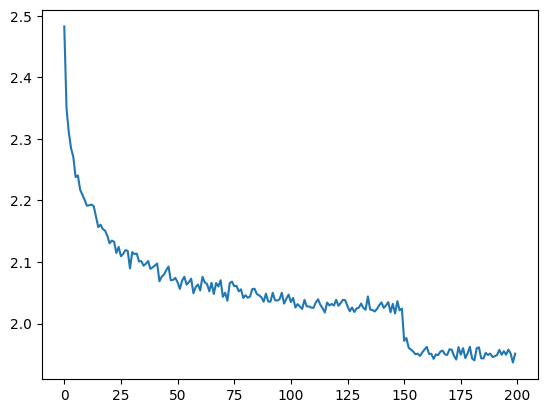

In [653]:
x = torch.tensor(lossi).view(-1,1000)
x = 10**x #to unravel the Log10

plt.plot(x.mean(1,keepdim=True));

In [654]:
# putting layers in eval mode
for layer in model.layers:
    layer.training = False

In [655]:
# model evaluation
@torch.no_grad
def calc_loss(x,y,dataset:str):
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(f'{dataset} loss: {loss.item():.4f}')

calc_loss(xtr,ytr,'train')
calc_loss(xval,yval,'val')

train loss: 1.9068
val loss: 2.0458


### Performance Log
1. Original - 3 Context length + 200hidden layer, BatchNorm
    - Context Lenght = *3*
    - Total Params = **12K**
    - train loss: **2.0331**
    - val loss: **2.1094**
2. Increased Context - 8 Context length, rest same
    - Context Lenght = *8*
    - Total Params = **22K**
    - train loss: **1.9068**
    - val loss: **2.0458**
3. 

In [656]:
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        '''
        we convert each row into a probability matrix, and then do multinomial sampling from it, wherein each sample
        is a index of the invidiual item in the original row, which is most likely
        ''' 
        logits =  model(torch.tensor([context]))
        probs = torch.softmax(logits,dim=1)
        # ----------------------
        ix = torch.multinomial(probs,num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break

    print(''.join(itos[i] for i in out))

besar.
rejian.
rosiree.
inzova.
berce.
enha.
fabus.
khys.
lumar.
sumai.
chesae.
luci.
live.
kwain.
aharloth.
henar.
jahtencer.
edess.
azot.
elifia.


tina.
aubrilyn.
amontaislandy.
mathalayanniella.
micaba.
jamel.
kalaya.
guna.
cri.
kenna.
omary.
dalynn.
jaixan.
kaena.
aith.
rion.
genesson.
dhuki.
kymbertlena.
yer.

In [630]:
context = [0] * block_size
model(torch.tensor([context]))

tensor([[ 0.0315,  0.0763,  0.0155,  0.0186, -0.0072,  0.0967, -0.1415,  0.0550,
          0.1330,  0.1224,  0.0171,  0.0627, -0.0111, -0.0412,  0.0131,  0.0780,
         -0.0294,  0.0960,  0.0774, -0.0474, -0.1192,  0.0273,  0.0766,  0.0049,
          0.1734,  0.0082,  0.0231]], grad_fn=<AddBackward0>)